In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
import math

# Task 1 Implementation of BEM Theory

## Part a: Without the Prandtl Tip loss Model

#### 1. Defining Parameters:

In [166]:
rho = 1.225                         #Density 
V = 0                               #Forward or climb speed of propeller or rotor
blades=b = 5                        #No of blades
rpm = 960                           #RPM
omega = 2*np.pi*rpm/60              #Rotation in radian/second

#### 2. Blade Dimensions:

In [167]:
R = 0.762                          #Radius
Rrc = 0.125                        #Root cut out
chord_length = 0.0508              #Cord length

#### 3. Defining Twist, Taper, Solidity

In [168]:
C0 = 0.08                          #Taper Length at the Root of Blade or cord length for constant value of taper
C1 = -0.05                         #slope of taper vs radius 
def linear_taper(r):
    return (C0+C1*(r-Rrc))

theta0 = 4                         #initial twist value or twist at the Root of Blade
theta1 = 0                         #Slope of twist value vs radius 
def linear_twist(r):
    return (theta0*math.pi/180 + (theta1*math.pi/180)*(r-Rrc))

def solidity(r):
    s_0 = (b*C0)/(math.pi*R)
    s_1 = (b*C1)/(math.pi*R)
    return (s_0 + s_1*(r-Rrc))

#### 4. defining function for calculating lambda

In [169]:
#Will return the value of lambda for given r 
def lamda(r):
    lambda_c = V/(omega*R)                           #lambda_c value
    temp1 = a*solidity(r)/16 - lambda_c/2
    temp2 = (solidity(r)*a*linear_twist(r)*r)/(8*R)
    temp3 = solidity(r)*a/16 - lambda_c/2
    ans = (temp1**2 + temp2)**0.5 - temp3
    return ans

#### 5. Defining cofficient of lift and Drag

In [171]:
a = 5.75                                  #value of Slope of Coefficient of Lift vs Effective Angle of Attack Curve

cd_min = 0.0113                          #min value of Coefficient of Drag
eps = 1.25                               #epsilon value

#function for calculating Coefficient of Lift value at r 
def Cl(r):
    alpha_eff = linear_twist(r)-math.atan(lamda(r)*R/r)
    return a*alpha_eff

#function for calculating Coefficient of Drag value at r 
def Cd(r):
    alpha_eff = linear_twist(r)-math.atan(lamda(r)*R/r)
    return cd_min + eps*(alpha_eff)**2

#### 6. Thrust and Torque calculation on Blade element

In [201]:
#Function for calculating Thrust on element of blade at r 
def dT(r):
    U_T = omega*r
    U_P = lamda(r)*R*omega
    theta_r = linear_twist(r)
    C_r = linear_taper(r)
    phi = math.atan(lamda(r)*R/r)
    ans = 0.5*rho*b*(U_T**2 + U_P**2)*C_r*(Cl(r)*math.cos(phi) - Cd(r)*math.sin(phi))
    return ans

#Function for calculating Torque on element of blade at r 
def dQ(r):
    U_T = omega*r
    U_P = lamda(r)*R*omega
    theta_r = linear_twist(r)
    C_r = linear_taper(r)
    phi = math.atan(lamda(r)*R/r)
    ans = 0.5*rho*r*b*(U_T**2 + U_P**2)*C_r*(Cl(r)*math.sin(phi) + Cd(r)*math.cos(phi))
    return ans

#### 7. Total Thrust and Torque

In [173]:
# calculation total thrust in Newton and coefficient of thrust
Thrust = quad(dT,Rrc,R)
Ct = (Thrust[0])/(rho*math.pi*(omega**2)*(R**4))
print (Thrust[0])
print (Ct)



# calculation total torque in Newton*Meter and coefficient of torque
Torque = quad(dQ,Rrc,R)
Cq = (Torque[0])/(rho*math.pi*(omega**2)*(R**5))
print(Torque[0])
print (Cq)


#calculation of total power in Watt and coefficient of power
Power = Torque[0]*omega
Cp = Cq
print (Power)
print (Cp)


30.28822951928209
0.0023097678862748997
18.03983069468382
0.0018053937605996809
1813.5615866375144
0.0018053937605996809


## Part b: With the Prandtl Tip loss model

#### 1,2,3 part will be same as above

#### 4. defining Factor F

In [174]:
def f(r,lamda_prev):
    return b*(1-r/R)/(2*lamda_prev)

#Function for calculating Factor F at given r and lambda value
def Factor(r,lamda_prev):
    return (2*math.acos(math.exp(-f(r,lamda_prev))))/math.pi

#### 5. Defining lamda with the tip loss model

In [175]:
#Function for calculating value of lambda after taking tip loss into account
def find_lamda_r(r):
    lamda_0 = 10
    delta = 100
    F=1
    while delta > 10**-8 :
        lambda_c = V/(omega*R)
        temp1 = a*solidity(r)/(16*F) - lambda_c/2
        temp2 = (solidity(r)*a*linear_twist(r)*r)/(8*R*F)
        temp3 = solidity(r)*a/(16*F) - lambda_c/2
        temp_lamda = (temp1**2 + temp2)**0.5 - temp3
        if temp_lamda == 0:
            break
        delta = abs(lamda_0 - temp_lamda)
        F = Factor(r,temp_lamda)
        #print(F)
        lamda_0 = temp_lamda
    return temp_lamda
    

#### 6. Defining cofficient of lift and drag for tip loss model


In [176]:
a = 5.75

cd_min = 0.0113
eps = 1.25

#Cofficient of lift and drag for tip loss model

def Cl_tip_loss(r):
    alpha_eff = linear_twist(r)-math.atan(find_lamda_r(r)*R/r)
    return a*alpha_eff

def Cd_tip_loss(r):
    alpha_eff = linear_twist(r)-math.atan(find_lamda_r(r)*R/r)
    return cd_min + eps*(alpha_eff)**2

#### 7. Calculate Torque and Thrust on blade element for tip loss model

In [200]:
#Function for calculating Thrust on element of blade at r for Tip Loss model 
def dT_tip_loss(r):
    U_T = omega*r
    U_P = find_lamda_r(r)*R*omega
    theta_r = linear_twist(r)
    C_r = linear_taper(r)
    phi = math.atan((find_lamda_r(r)*R)/r)
    ans = 0.5*rho*b*(U_T**2 + U_P**2)*C_r*(Cl_tip_loss(r)*math.cos(phi) - Cd_tip_loss(r)*math.sin(phi))
    return ans

#Function for calculating Torque on element of blade at r for Tip Loss model 
def dQ_tip_loss(r):
    U_T = omega*r
    U_P = find_lamda_r(r)*R*omega
    theta_r = linear_twist(r)
    C_r = linear_taper(r)
    phi = math.atan(find_lamda_r(r)*R/r)
    ans = 0.5*rho*r*b*(U_T**2 + U_P**2)*C_r*(Cl_tip_loss(r)*math.sin(phi) + Cd_tip_loss(r)*math.cos(phi))
    return ans

#### 8. Total Thrust and Torque for Tip loss model

In [178]:
# calculation total thrust in Newton and coefficient of thrust for Tip loss model
Thrust_tip_loss = quad(dT_tip_loss,Rrc,R)
Ct_tip_loss = (Thrust[0])/(rho*math.pi*(omega**2)*(R**4))
print (Thrust_tip_loss[0])
print (Ct_tip_loss)


# calculation total torque in Newton*Meter and coefficient of torque for Tip loss model
Torque_tip_loss = quad(dQ_tip_loss,Rrc,R)
Cq_tip_loss = (Torque_tip_loss[0])/(rho*math.pi*(omega**2)*(R**5))
print(Torque_tip_loss[0])
print (Cq_tip_loss)


#calculation of total power in Watt and coefficient of power for Tip loss model
Power_tip_loss = Torque_tip_loss[0]*omega
Cp_tip_loss = Cq_tip_loss
print (Power_tip_loss)
print (Cp_tip_loss)


29.55841030909628
0.0023097678862748997
17.492790090705707
0.0017506469223431663
1758.56706687198
0.0017506469223431663


# Results and Experiment

## 1. CT and CQ analysis with theta0 and Comparison with experimental values


In [202]:
CT_paper = [0,0.000287,0.0010420,0.00214,0.00338,0.00473,0.00645,0.00792,0.00981,0.01182,0.01382,0.01596,0.01745]
CQ_paper = [0.000268,0.000274,0.0003000,0.000338,0.000410,0.000499,0.000620,0.000743,0.000920,0.001162,0.001395,0.00171,0.00191]

In [203]:
CT_paper_modified = np.array(CT_paper)/2
CQ_paper_modified = np.array(CQ_paper)/2

In [204]:
#Parameteres:
rpm = 960                           #RPM
omega = 2*np.pi*rpm/60
R = 0.762                          #Radius
Rrc = 0.125                        #Root cut out
chord_length = 0.0508              #Cord length
blades=b = 4 

C0 = chord_length                       
C1 = 0
theta1=0

a = 5.75

cd_min = 0.0113
eps = 1.25

In [205]:
theta0_list = np.array([0,1,2,3,4,5,6,7,8,9,10,11,12])
CT_without_tip_loss_list = np.zeros(len(theta0_list))
CQ_without_tip_loss_list = np.zeros(len(theta0_list))
CT_tip_loss_list = np.zeros(len(theta0_list))
CQ_tip_loss_list = np.zeros(len(theta0_list))
P_without_tip_loss_list = np.zeros(len(theta0_list))
P_tip_loss_list = np.zeros(len(theta0_list))

In [206]:
for i in range(len(theta0_list)):
    theta0 = theta0_list[i]
    Thrust_without_tip_loss = quad(dT,Rrc,R)
    Ct_without_tip_loss = (Thrust_without_tip_loss[0])/(rho*math.pi*(omega**2)*(R**4))
    CT_without_tip_loss_list[i] = Ct_without_tip_loss 
    
    Thrust_tip_loss = quad(dT_tip_loss,Rrc,R)
    Ct_tip_loss = (Thrust_tip_loss[0])/(rho*math.pi*(omega**2)*(R**4))
    CT_tip_loss_list[i] = Ct_tip_loss
    
    Torque_without_tip_loss = quad(dQ,Rrc,R)
    Cq_without_tip_loss = (Torque_without_tip_loss[0])/(rho*math.pi*(omega**2)*(R**5))
    CQ_without_tip_loss_list[i] = Cq_without_tip_loss
    
    Torque_tip_loss = quad(dQ_tip_loss,Rrc,R)
    Cq_tip_loss = (Torque_tip_loss[0])/(rho*math.pi*(omega**2)*(R**5))
    CQ_tip_loss_list[i] = Cq_tip_loss

    Power_without_tip_loss = Torque_without_tip_loss[0]*omega
    P_without_tip_loss_list[i] = Power_without_tip_loss
    Power_tip_loss = Torque_tip_loss[0]*omega
    P_tip_loss_list[i] =Power_tip_loss

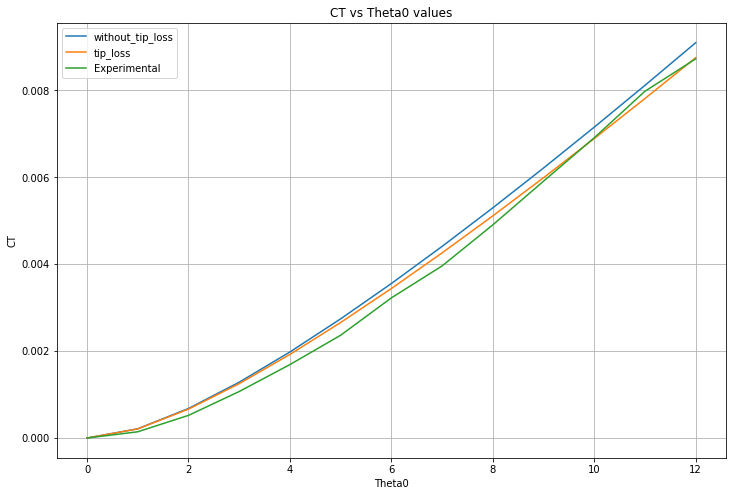

In [215]:
plt.figure(figsize=(12,8))
plt.plot(theta0_list,CT_without_tip_loss_list,label="without_tip_loss")
plt.plot(theta0_list,CT_tip_loss_list,label="tip_loss")
plt.plot(theta0_list,CT_paper_modified,label="Experimental")
plt.title("CT vs Theta0 values")
plt.xlabel("Theta0")
plt.ylabel("CT")
plt.legend()
plt.grid()

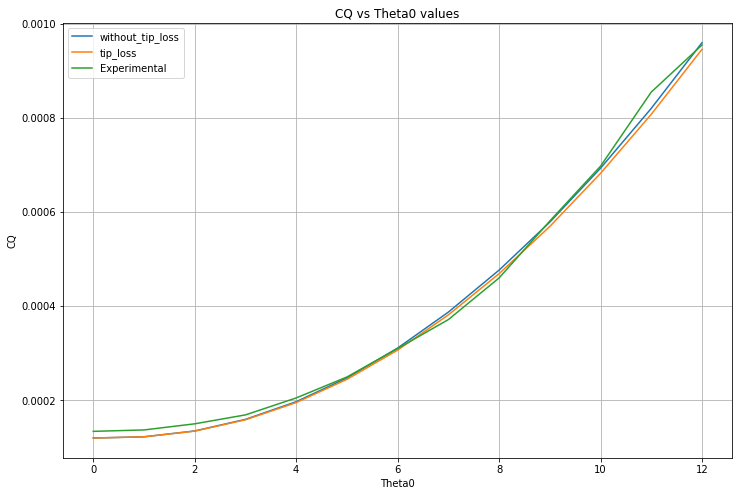

In [214]:
plt.figure(figsize=(12,8))
plt.plot(theta0_list,CQ_without_tip_loss_list,label="without_tip_loss")
plt.plot(theta0_list,CQ_tip_loss_list,label="tip_loss")
plt.plot(theta0_list,CQ_paper_modified,label="Experimental")
plt.title("CQ vs Theta0 values")
plt.xlabel("Theta0")
plt.ylabel("CQ")
plt.legend()
plt.grid()

## 2. Sectional thrust 

In [1148]:
#Parameters:
rpm = 960                           #RPM
omega = 2*np.pi*rpm/60
R = 0.762                          #Radius
Rrc = 0.125                        #Root cut out
chord_length = 0.0508              #Cord length
blades=b = 4 

C0 = chord_length                       
C1 = 0
theta1=0

a = 5.75

cd_min = 0.0113
eps = 1.25

In [1735]:
delta_r = (R-Rrc)/40000
r_values = np.linspace(Rrc,R-delta_r,40000)


In [1736]:
sectional_thrust_tip_loss = np.zeros(40000)
sectional_thrust_without_tip_loss = np.zeros(40000)


#### 1. For Twist = 0  

In [1170]:
theta0 = theta0_list[0]
for i in range(len(r_values)):
    sectional_thrust_tip_loss[i] = dT_tip_loss(r_values[i])
    sectional_thrust_without_tip_loss[i] = dT(r_values[i])

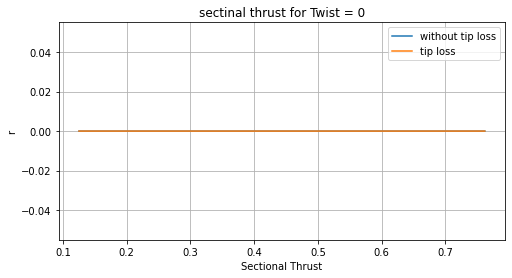

In [1171]:
plt.figure(figsize=(8,4))
plt.plot(r_values,sectional_thrust_without_tip_loss,label='without tip loss')
plt.plot(r_values,sectional_thrust_tip_loss,label="tip loss")
plt.xlabel("Sectional Thrust")
plt.ylabel("r")
plt.title('sectinal thrust for Twist = 0')
plt.legend()
plt.grid()
plt.savefig("sectional_thrust_0")

#### 2. for twist = 2 degree 

In [1153]:
theta0 = theta0_list[2]

In [1154]:
for i in range(len(r_values)):
    sectional_thrust_tip_loss[i] = dT_tip_loss(r_values[i])
    sectional_thrust_without_tip_loss[i] = dT(r_values[i])

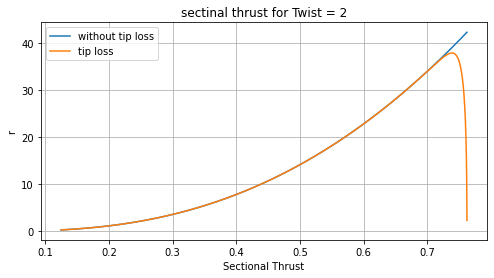

In [1157]:
plt.figure(figsize=(8,4))
plt.plot(r_values,sectional_thrust_without_tip_loss,label='without tip loss')
plt.plot(r_values,sectional_thrust_tip_loss,label="tip loss")
plt.xlabel("Sectional Thrust")
plt.ylabel("r")
plt.title('sectinal thrust for Twist = 2')
plt.legend()
plt.grid()
plt.savefig("sectional_thrust_2")

#### 3. for Twist = 4 degree

In [1158]:
theta0 = theta0_list[4]

In [1159]:
for i in range(len(r_values)):
    sectional_thrust_tip_loss[i] = dT_tip_loss(r_values[i])
    sectional_thrust_without_tip_loss[i] = dT(r_values[i])

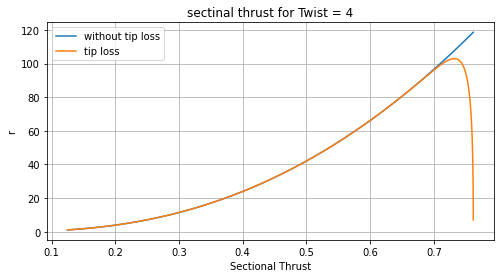

In [1160]:
plt.figure(figsize=(8,4))
plt.plot(r_values,sectional_thrust_without_tip_loss,label='without tip loss')
plt.plot(r_values,sectional_thrust_tip_loss,label="tip loss")
plt.xlabel("Sectional Thrust")
plt.ylabel("r")
plt.title('sectinal thrust for Twist = 4')
plt.legend()
plt.grid()
plt.savefig("sectional_thrust_4")

#### 4. For twist = 6 degree

In [1161]:
theta0 = theta0_list[6]

In [1162]:
for i in range(len(r_values)):
    sectional_thrust_tip_loss[i] = dT_tip_loss(r_values[i])
    sectional_thrust_without_tip_loss[i] = dT(r_values[i])

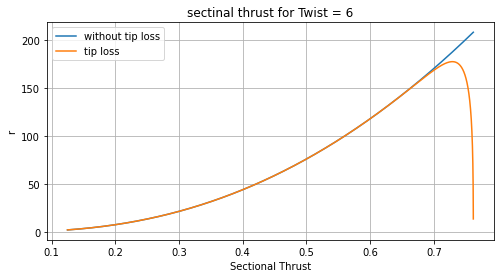

In [1163]:
plt.figure(figsize=(8,4))
plt.plot(r_values,sectional_thrust_without_tip_loss,label='without tip loss')
plt.plot(r_values,sectional_thrust_tip_loss,label="tip loss")
plt.xlabel("Sectional Thrust")
plt.ylabel("r")
plt.title('sectinal thrust for Twist = 6')
plt.legend()
plt.grid()
plt.savefig("sectional_thrust_6")

#### 5. For Twist = 8 degree

In [1164]:
theta0 =theta0_list[8]

In [1165]:
for i in range(len(r_values)):
    sectional_thrust_tip_loss[i] = dT_tip_loss(r_values[i])
    sectional_thrust_without_tip_loss[i] = dT(r_values[i])

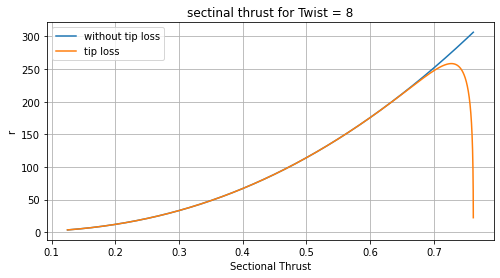

In [1166]:
plt.figure(figsize=(8,4))
plt.plot(r_values,sectional_thrust_without_tip_loss,label='without tip loss')
plt.plot(r_values,sectional_thrust_tip_loss,label="tip loss")
plt.xlabel("Sectional Thrust")
plt.ylabel("r")
plt.title('sectinal thrust for Twist = 8')
plt.legend()
plt.grid()
plt.savefig("sectional_thrust_8")

#### 6. For Twist = 10 degree 

In [1167]:
theta0 =theta0_list[10]

In [1168]:
for i in range(len(r_values)):
    sectional_thrust_tip_loss[i] = dT_tip_loss(r_values[i])
    sectional_thrust_without_tip_loss[i] = dT(r_values[i])

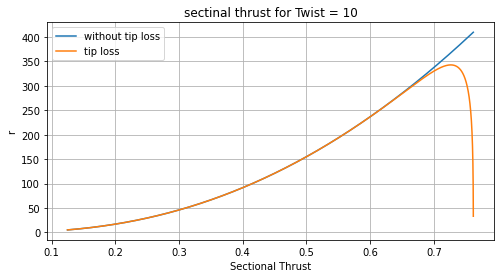

In [1169]:
plt.figure(figsize=(8,4))
plt.plot(r_values,sectional_thrust_without_tip_loss,label='without tip loss')
plt.plot(r_values,sectional_thrust_tip_loss,label="tip loss")
plt.xlabel("Sectional Thrust")
plt.ylabel("r")
plt.title('sectinal thrust for Twist = 10')
plt.legend()
plt.grid()
plt.savefig("sectional_thrust_10")

## 3. Rotor Design 

In [1172]:
#Fixed Parameters
rho = 1.225
R = 0.3                     #From previous assignment
Rrc = 0.05                  #approximate 
Thrust_needed = 220         #220 Newton thrust (from previous assignment)


V = 0                               #Forward or climb speed of propeller or rotor
blades=b = 3000


rpm = 3000                          #RPM
omega = 2*np.pi*rpm/60              #Rotation in radian/second

In [1173]:
C0=0.08
#for no overlape:
2*np.pi*Rrc - C0*b > 0

True

In [1174]:
def figure_of_merit(Power_MT, Power_BEMT):
    return Power_MT/Power_BEMT

#### Taper slope selection

In [1219]:
C1_list = np.linspace(-0.3,0.3,20)

In [1176]:
C1_list

array([-0.3       , -0.26842105, -0.23684211, -0.20526316, -0.17368421,
       -0.14210526, -0.11052632, -0.07894737, -0.04736842, -0.01578947,
        0.01578947,  0.04736842,  0.07894737,  0.11052632,  0.14210526,
        0.17368421,  0.20526316,  0.23684211,  0.26842105,  0.3       ])

In [1177]:
CT_taper_variation = np.zeros(20)
CQ_taper_variation = np.zeros(20)
Power_taper_variation = np.zeros(20)
Thrust_taper_variation = np.zeros(20)

In [1207]:

theta0 = 12
theta1 = -3
for i in range(len(C1_list)):
    C1 = C1_list[i]
    
    Thrust_tip_loss = quad(dT_tip_loss,Rrc,R)
    Thrust_taper_variation[i] = Thrust_tip_loss[0]
    Ct_tip_loss = (Thrust_tip_loss[0])/(rho*math.pi*(omega**2)*(R**4))
    CT_taper_variation[i] = Ct_tip_loss
    
    Torque_tip_loss = quad(dQ_tip_loss,Rrc,R)
    Cq_tip_loss = (Torque_tip_loss[0])/(rho*math.pi*(omega**2)*(R**5))
    CQ_taper_variation[i] = Cq_tip_loss


    Power_tip_loss = Torque_tip_loss[0]*omega
    Power_taper_variation[i] =Power_tip_loss

In [1208]:
C1_list


array([-0.3       , -0.26842105, -0.23684211, -0.20526316, -0.17368421,
       -0.14210526, -0.11052632, -0.07894737, -0.04736842, -0.01578947,
        0.01578947,  0.04736842,  0.07894737,  0.11052632,  0.14210526,
        0.17368421,  0.20526316,  0.23684211,  0.26842105,  0.3       ])

In [1209]:
Thrust_taper_variation

array([23.45104688, 27.41070513, 30.77756643, 33.72459363, 36.35024899,
       38.71901056, 40.87643722, 42.8563492 , 44.68475163, 46.38217942,
       47.96519112, 49.44736801, 50.8400078 , 52.15262169, 53.39329981,
       54.56898524, 55.68568384, 56.74862723, 57.76240119, 58.73104813])

In [1210]:
def test(x, a, b): 
    return a*x +b

from scipy.optimize import curve_fit 
param, param_cov = curve_fit(test, C1_list, CT_taper_variation)

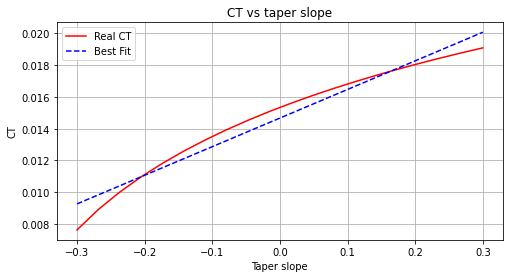

In [1216]:

ans = param[0]*C1_list + param[1]
  
plt.figure(figsize=(8,4))
plt.plot(C1_list, CT_taper_variation, color ='red', label ="Real CT") 
plt.plot(C1_list, ans, '--', color ='blue', label ="Best Fit") 



plt.xlabel("Taper slope")
plt.ylabel("CT")
plt.title('CT vs taper slope')
plt.legend()
plt.grid()
plt.savefig("CT vs taper slope")

In [1212]:
param_p, param_cov_p = curve_fit(test, C1_list, CQ_taper_variation)

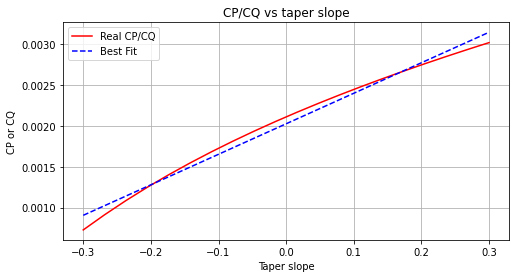

In [1217]:

CP_best_fit = param_p[0]*C1_list + param_p[1]
plt.figure(figsize=(8,4))
plt.plot(C1_list, CQ_taper_variation, color ='red', label ="Real CP/CQ") 
plt.plot(C1_list, CP_best_fit, '--', color ='blue', label ="Best Fit") 

plt.xlabel("Taper slope")
plt.ylabel("CP or CQ")
plt.title('CP/CQ vs taper slope')
plt.legend()
plt.grid()
plt.savefig("CPCQ vs taper slope")
 

In [1214]:
param_power, param_cov_power = curve_fit(test, C1_list, Power_taper_variation)

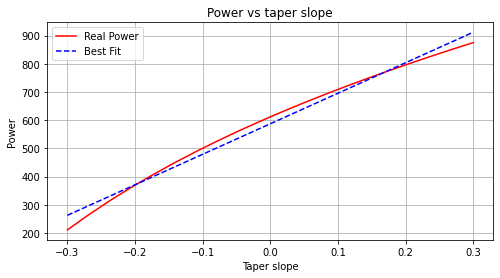

In [1218]:

P_best_fit = param_power[0]*C1_list + param_power[1]
plt.figure(figsize=(8,4))
plt.plot(C1_list, Power_taper_variation, color ='red', label ="Real Power") 
plt.plot(C1_list, P_best_fit, '--', color ='blue', label ="Best Fit") 

plt.xlabel("Taper slope")
plt.ylabel("Power")
plt.title('Power vs taper slope')
plt.legend()
plt.grid()
plt.savefig("Power vs taper slope")
 

#### Twist Variation

In [1236]:
theta0 = 12
theta1_list = np.linspace(-8,8,20)

C0 = 0.08
C1 = 0.055

In [1237]:
CT_twist_variation = np.zeros(20)
CQ_twist_variation = np.zeros(20)
Power_twist_variation = np.zeros(20)
Thrust_twist_variation = np.zeros(20)

In [1239]:
for i in range(len(theta1_list)):
    theta1 = theta1_list[i]
    
    Thrust_tip_loss = quad(dT_tip_loss,Rrc,R)
    Thrust_twist_variation[i] = Thrust_tip_loss[0]
    Ct_tip_loss = (Thrust_tip_loss[0])/(rho*math.pi*(omega**2)*(R**4))
    CT_twist_variation[i] = Ct_tip_loss
    
    Torque_tip_loss = quad(dQ_tip_loss,Rrc,R)
    Cq_tip_loss = (Torque_tip_loss[0])/(rho*math.pi*(omega**2)*(R**5))
    CQ_twist_variation[i] = Cq_tip_loss


    Power_tip_loss = Torque_tip_loss[0]*omega
    Power_twist_variation[i] =Power_tip_loss

In [1240]:
Thrust_twist_variation

array([44.16822038, 45.1023475 , 46.04182775, 46.98659035, 47.93656698,
       48.89169164, 49.85190052, 50.81713198, 51.78732623, 52.76242561,
       53.74237403, 54.72711734, 55.71660298, 56.71077995, 57.7095988 ,
       58.71301153, 59.72097153, 60.73343349, 61.75035345, 62.77168864])

In [1241]:
theta1_list

array([-8.        , -7.15789474, -6.31578947, -5.47368421, -4.63157895,
       -3.78947368, -2.94736842, -2.10526316, -1.26315789, -0.42105263,
        0.42105263,  1.26315789,  2.10526316,  2.94736842,  3.78947368,
        4.63157895,  5.47368421,  6.31578947,  7.15789474,  8.        ])

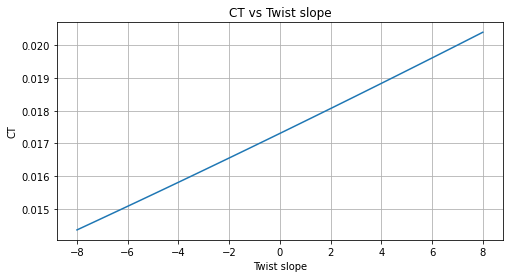

In [1244]:
plt.figure(figsize=(8,4))
plt.plot(theta1_list,CT_twist_variation)
plt.xlabel("Twist slope")
plt.ylabel("CT")
plt.title('CT vs Twist slope')
#plt.legend()
plt.grid()
plt.savefig("CT vs Twist slope")
 

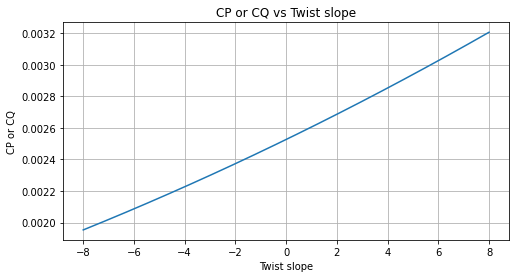

In [1245]:
plt.figure(figsize=(8,4))
plt.plot(theta1_list,CQ_twist_variation)
plt.xlabel("Twist slope")
plt.ylabel("CP or CQ")
plt.title('CP or CQ vs Twist slope')
#plt.legend()
plt.grid()
plt.savefig("CPCQ vs Twist slope")

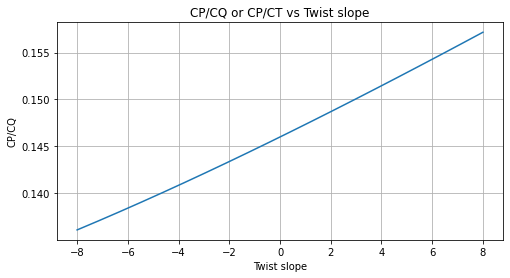

In [1247]:
plt.figure(figsize=(8,4))
plt.plot(theta1_list,CQ_twist_variation/CT_twist_variation)
plt.xlabel("Twist slope")
plt.ylabel("CP/CQ")
plt.title('CP/CQ or CP/CT vs Twist slope')
#plt.legend()
plt.grid()
plt.savefig("CPbyCQ vs Twist slope")

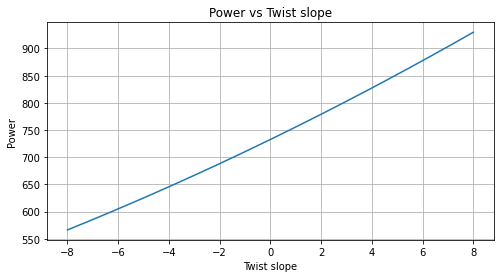

In [1248]:

plt.figure(figsize=(8,4))
plt.plot(theta1_list,Power_twist_variation)
plt.xlabel("Twist slope")
plt.ylabel("Power")
plt.title('Power vs Twist slope')
#plt.legend()
plt.grid()
plt.savefig("Power vs Twist slope")

###### Theta_0 variation

In [1265]:
theta0_list = np.linspace(4,14,11)
theta1 = 2

C0 = 0.08
C1 = 0.055

In [1266]:
CT_theta0_variation = np.zeros(11)
CQ_theta0_variation = np.zeros(11)
Power_theta0_variation = np.zeros(11)
Thrust_theta0_variation = np.zeros(11)

In [1267]:
for i in range(len(theta0_list)):
    theta0 = theta0_list[i]
    
    Thrust_tip_loss = quad(dT_tip_loss,Rrc,R)
    Thrust_theta0_variation[i] = Thrust_tip_loss[0]
    Ct_tip_loss = (Thrust_tip_loss[0])/(rho*math.pi*(omega**2)*(R**4))
    CT_theta0_variation[i] = Ct_tip_loss
    
    Torque_tip_loss = quad(dQ_tip_loss,Rrc,R)
    Cq_tip_loss = (Torque_tip_loss[0])/(rho*math.pi*(omega**2)*(R**5))
    CQ_theta0_variation[i] = Cq_tip_loss


    Power_tip_loss = Torque_tip_loss[0]*omega
    Power_theta0_variation[i] =Power_tip_loss

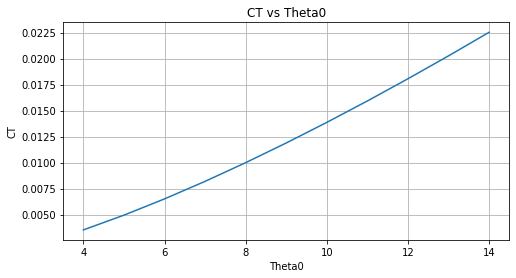

In [1268]:
plt.figure(figsize=(8,4))
plt.plot(theta0_list,CT_theta0_variation)
plt.xlabel("Theta0")
plt.ylabel("CT")
plt.title('CT vs Theta0')
#plt.legend()
plt.grid()
plt.savefig("CT vs Theta0")

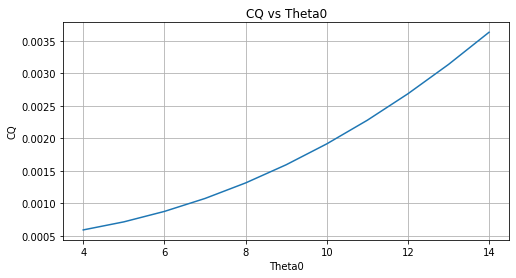

In [1269]:
plt.figure(figsize=(8,4))
plt.plot(theta0_list,CQ_theta0_variation)
plt.xlabel("Theta0")
plt.ylabel("CQ")
plt.title('CQ vs Theta0')
#plt.legend()
plt.grid()
plt.savefig("CQ vs Theta0")

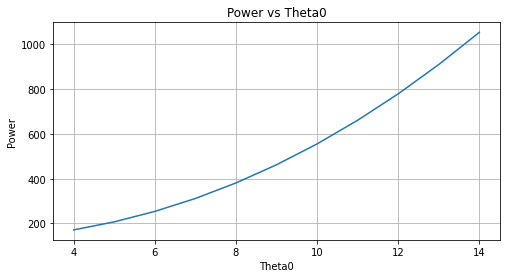

In [1270]:
plt.figure(figsize=(8,4))
plt.plot(theta0_list,Power_theta0_variation)
plt.xlabel("Theta0")
plt.ylabel("Power")
plt.title('Power vs Theta0')
#plt.legend()
plt.grid()
plt.savefig("Power vs Theta0")

# 4. Propeller Design

In [1673]:
#Fixed Parameters
rho = 1.225
R = 0.3                     #From previous assignment
Rrc = 0.05                  #approximate 
Thrust_needed = 40         #220 Newton thrust (from previous assignment)


V = 22.22                               #Forward or climb speed of propeller or rotor
blades=b = 2


rpm = 1500                          #RPM
omega = 2*np.pi*rpm/60              #Rotation in radian/second

In [1674]:
C0=0.08
#for no overlape:
2*np.pi*Rrc - C0*b > 0

True

### Taper slope Variation

In [1675]:
C1_list = np.linspace(-0.3,0.3,20)

In [1676]:
CT_taper_variation_prop = np.zeros(20)
CQ_taper_variation_prop = np.zeros(20)
Power_taper_variation_prop = np.zeros(20)
Thrust_taper_variation_prop = np.zeros(20)
theta0 = 45
theta1 = 0
for i in range(len(C1_list)):
    C1 = C1_list[i]
    
    Thrust_tip_loss = quad(dT_tip_loss,Rrc,R)
    Thrust_taper_variation_prop[i] = Thrust_tip_loss[0]
    Ct_tip_loss = (Thrust_tip_loss[0])/(rho*math.pi*(omega**2)*(R**4))
    CT_taper_variation_prop[i] = Ct_tip_loss
    
    Torque_tip_loss = quad(dQ_tip_loss,Rrc,R)
    Cq_tip_loss = (Torque_tip_loss[0])/(rho*math.pi*(omega**2)*(R**5))
    CQ_taper_variation_prop[i] = Cq_tip_loss


    Power_tip_loss = Torque_tip_loss[0]*omega
    Power_taper_variation_prop[i] =Power_tip_loss

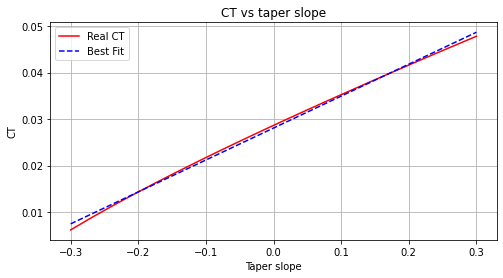

In [1677]:
param_prop, param_cov_prop = curve_fit(test, C1_list, CT_taper_variation_prop)
ans_prop = param_prop[0]*C1_list + param_prop[1]
  
plt.figure(figsize=(8,4))
plt.plot(C1_list, CT_taper_variation_prop, color ='red', label ="Real CT") 
plt.plot(C1_list, ans_prop, '--', color ='blue', label ="Best Fit") 



plt.xlabel("Taper slope")
plt.ylabel("CT")
plt.title('CT vs taper slope')
plt.legend()
plt.grid()
plt.savefig("CT vs taper slope for propeller")

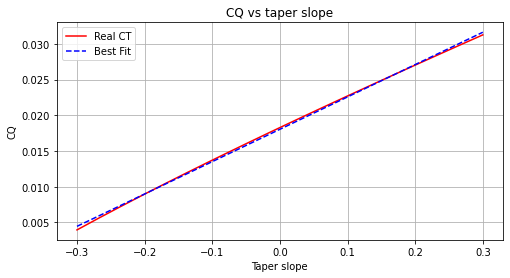

In [1678]:
param_prop_cq, param_cov_prop_cq = curve_fit(test, C1_list, CQ_taper_variation_prop)
ans_prop_cq = param_prop_cq[0]*C1_list + param_prop_cq[1]
  
plt.figure(figsize=(8,4))
plt.plot(C1_list, CQ_taper_variation_prop, color ='red', label ="Real CT") 
plt.plot(C1_list, ans_prop_cq, '--', color ='blue', label ="Best Fit") 



plt.xlabel("Taper slope")
plt.ylabel("CQ")
plt.title('CQ vs taper slope')
plt.legend()
plt.grid()
plt.savefig("CQ vs taper slope for propeller")

No handles with labels found to put in legend.


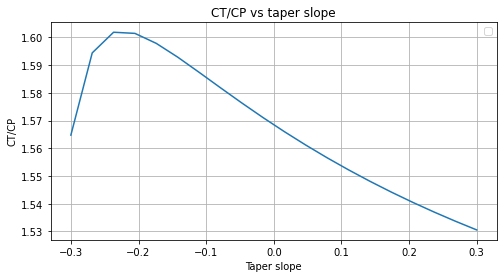

In [1679]:
plt.figure(figsize=(8,4))
plt.plot(C1_list, CT_taper_variation_prop/CQ_taper_variation_prop)
plt.xlabel("Taper slope")
plt.ylabel("CT/CP")
plt.title('CT/CP vs taper slope')
plt.legend()
plt.grid()
plt.savefig("CTbyCP vs taper slope for propeller")

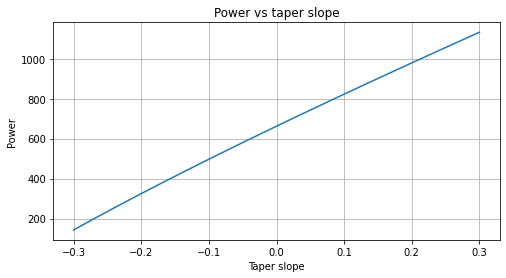

In [1680]:
plt.figure(figsize=(8,4))
plt.plot(C1_list, Power_taper_variation_prop)
plt.xlabel("Taper slope")
plt.ylabel("Power")
plt.title('Power vs taper slope')
#plt.legend()
plt.grid()
plt.savefig("Power vs taper slope for propeller")

In [1681]:
Power_taper_variation_prop

array([ 143.04785991,  201.72546994,  259.14946405,  315.48494324,
        370.86290608,  425.39009556,  479.15525842,  532.23334107,
        584.68843373,  636.57591208,  687.94404022,  738.8351987 ,
        789.28684367,  839.33226826,  889.00121553,  938.3203779 ,
        987.31380828, 1036.00326207, 1084.4084835 , 1132.54744766])

In [1682]:
Thrust_taper_variation_prop

array([ 4.74990391,  6.82523262,  8.80909218, 10.72130632, 12.57484581,
       14.37901938, 16.14087429, 17.8659406 , 19.5586728 , 21.22273169,
       22.86117432, 24.47658723, 26.07118296, 27.64687192, 29.20531699,
       30.74797582, 32.27613417, 33.79093245, 35.29338722, 36.7844087 ])

In [1606]:
C1_list

array([-0.3       , -0.26842105, -0.23684211, -0.20526316, -0.17368421,
       -0.14210526, -0.11052632, -0.07894737, -0.04736842, -0.01578947,
        0.01578947,  0.04736842,  0.07894737,  0.11052632,  0.14210526,
        0.17368421,  0.20526316,  0.23684211,  0.26842105,  0.3       ])

#### Twist variation

In [1612]:
C0=0.08
C1=-0.02

In [1619]:
theta0_list_prop = np.linspace(35,54,20)

In [1622]:
CT_twist_variation_prop = np.zeros(20)
CQ_twist_variation_prop = np.zeros(20)
Power_twist_variation_prop = np.zeros(20)
Thrust_twist_variation_prop = np.zeros(20)
#theta0 = 45
theta1 = 0
for i in range(len(theta0_list_prop)):
    theta0 = theta0_list_prop[i]
    
    Thrust_tip_loss = quad(dT_tip_loss,Rrc,R)
    Thrust_twist_variation_prop[i] = Thrust_tip_loss[0]
    Ct_tip_loss = (Thrust_tip_loss[0])/(rho*math.pi*(omega**2)*(R**4))
    CT_twist_variation_prop[i] = Ct_tip_loss
    
    Torque_tip_loss = quad(dQ_tip_loss,Rrc,R)
    Cq_tip_loss = (Torque_tip_loss[0])/(rho*math.pi*(omega**2)*(R**5))
    CQ_twist_variation_prop[i] = Cq_tip_loss


    Power_tip_loss = Torque_tip_loss[0]*omega
    Power_twist_variation_prop[i] =Power_tip_loss

No handles with labels found to put in legend.


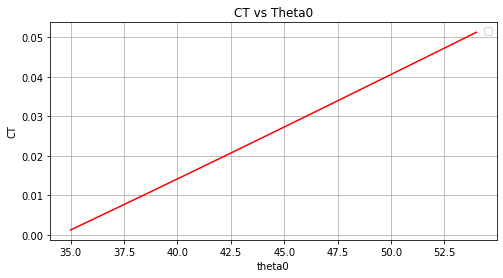

In [1626]:
plt.figure(figsize=(8,4))
plt.plot(theta0_list_prop, CT_twist_variation_prop, color ='red') 
#plt.plot(C1_list, ans_prop_cq, '--', color ='blue', label ="Best Fit") 



plt.xlabel("theta0")
plt.ylabel("CT")
plt.title('CT vs Theta0')
plt.legend()
plt.grid()
plt.savefig("CT vs theta0 for propeller")

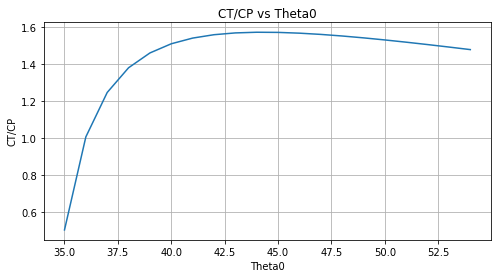

In [1625]:
plt.figure(figsize=(8,4))
plt.plot(theta0_list_prop, CT_twist_variation_prop/CQ_twist_variation_prop)
plt.xlabel("Theta0")
plt.ylabel("CT/CP")
plt.title('CT/CP vs Theta0')
#plt.legend()
plt.grid()
plt.savefig("CTbyCP vs theta0 slope for propeller")

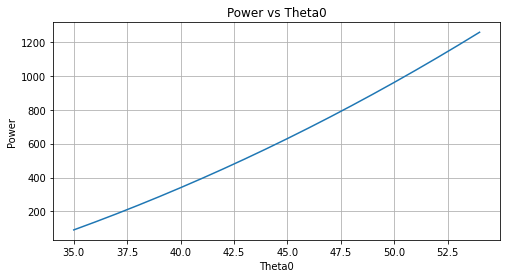

In [1627]:
plt.figure(figsize=(8,4))
plt.plot(theta0_list_prop, Power_twist_variation_prop)
plt.xlabel("Theta0")
plt.ylabel("Power")
plt.title('Power vs Theta0')
#plt.legend()
plt.grid()
plt.savefig("Power vs Theta0 for propeller")

### For calculating Thrust and Power for any value value of C0,C1, theta0, theta1 and RPM

In [1630]:
rpm=1500
omega=np.pi*2*rpm/60


In [1713]:
theta0 = 45
theta1= 0
C0 = 0.08
C1 = -0.039

In [1722]:
print("Thrust:  "+str(quad(dT_tip_loss,Rrc,R)[0]))

Thrust:  20.002305774568462


In [1723]:
Torque_frrrrr = quad(dQ_tip_loss,Rrc,R)
print('Power:'+str(Torque_frrrrr[0]*omega))

Power:598.4917964552225
